In [1]:
#Connection Objects

## Load the packages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
from statsmodels.stats.power import TTestIndPower
from getpass import getpass
import datetime as dt
import snowflake.connector


In [67]:
sf_password = getpass()

con = snowflake.connector.connect(
    account="shipt.us-east-1",
    user="navin@shipt.com",
    password=sf_password,
    database="PRD_DATALAKEHOUSE",
    warehouse="PRD_DATA_SCIENTIST_WHS",
    authenticator="https://shipt.okta.com"
)


 ············


In [3]:
#Outliers Function

def remove_outliers(df,col):
    
    q75 = df[col].quantile(0.75)
    q25 = df[col].quantile(0.25)
    iqr = q75-q25
    
    upper = q75+iqr
    lower = q25-iqr
    
    df_clean = df[(df[col]>=lower) & (df[col]<=upper)]
    
    return df_clean


In [109]:
dataset = '''

with shopper_cohorts as ( --cohorts
 select 
  sc.driver_id,
  sc.PAST_4_WEEKS_ORDER_CNT,
  sc.PAST_8_WEEKS_ORDER_CNT,
  sc.past_4_weeks_avg,
  sc.past_8_weeks_avg
 from data_science_sandbox.sc_shopper_cohorts sc
 join ops_analytics.shopper_stats ss
  on ss.driver_id = sc.driver_id
  and ss.platform_status = 'Active'
 where wk = '2022-11-14'
  and sc.cumulative_orders >= 10
  and sc.current_state <> 'Inactive'
  and datediff('week',ss.first_local_delivered_at, DATE('2022-11-24')) >= 4
),

signups as ( --avg signups
  select 
    ss.driver_id,
    d.final_approved_at_utc as hired_at,
    ss.created_at,
    coalesce(ss.deleted_at, DATE('2025-02-02')) as deleted_at,
    ss.time_slot_id,
    ts.starts_at,
    convert_timezone('UTC', m.time_zone, ts.starts_at::timestamp_ntz) as local_starts_at,
    ts.starts_at::date as dw_date,
    hour(ts.starts_at) as dw_hour,
    dayname(ts.starts_at::date) as day,
    m.metro as metro,
    m.region as region,
    z.name as zone,    
    datediff('minute', ss.created_at,coalesce(ss.deleted_at, DATE('2025-02-02'))) as sign_period
    
  from ops_analytics.shopper_signups ss
  join ops_analytics.shopper_stats d on d.driver_id = ss.driver_id
  join og_views.time_slots ts on ts.id = ss.time_slot_id
  join data_science.ops_metros m on m.metro_id = ts.metro_id
  join og_views.zones z on z.id = ts.zone_id
  
  where ts.starts_at > d.final_approved_at_utc 
   and ts.starts_at < coalesce(d.deactivated_at_utc, DATE('2025-02-02'))
   and ts.starts_at::date between date_trunc('week',current_date::date)-interval '4 weeks' and date_trunc('week',current_date::date)-interval '1 week'
   and sign_period >= 15 
),

window_signups as (
  select
   driver_id,
   hired_at,
   starts_at,
   --local_starts_at,
   date_trunc('week',starts_at::date) as week,
   dw_date,
   dw_hour,
   day,
   --metro,
   min(created_at) as first_created_at,
   max(deleted_at) as last_deleted_at
  from signups
  group by 1,2,3,4,5,6,7

),

weekly_signups as (
select
 driver_id,
 week,
 count(starts_at) as signup_count
from window_signups
group by 1,2  
),

shopper_signups as (
 select 
  ss.driver_id,
  w.week_cnt,
  sum(signup_count) as total_signups,
  total_signups/w.week_cnt as avg_signups
 from weekly_signups ss
 join (select count(distinct week) as week_cnt from window_signups) w on 1=1
 group by 1,2
),

bench as ( --peak hour work
select 
 metro,
 count(*) as cnt,
 round((0.25 * cnt),0) as level, 
 stddev(signup_order_ratio) as sd,
 avg(signup_order_ratio) as mean,
 sd/mean as cov 
from data_science_sandbox.nkk_peak_hours
group by 1
),

all_peaks as (
 select 
 p.*,
 b.level, 
 row_number() over (partition by p.metro order by p.signup_order_ratio) as rnk
 from data_science_sandbox.nkk_peak_hours p
 join bench b on b.metro = p.metro
 qualify rnk <= b.level
),

ods as (
 select
  os.driver_id,
  os.order_id,
  os.local_delivery_window,
  os.metro as metro,
  hour(os.local_delivery_window) as dw_hour,
  dayname(os.local_delivery_window) as day,
  p.signup_order_ratio,
  iff(p.signup_order_ratio is not null,1,0) as peak_hour
 from ops_analytics.order_stats os
 left join all_peaks p 
  on p.metro = os.metro
  and p.day = dayname(os.local_delivery_window)
  and p.dw_hour = hour(os.local_delivery_window)
 where
  os.order_status = 'delivered'
  and os.store_location_id not in (select distinct store_location_id from ng_views.metropolis_store_location where is_fulfillment_center)
 qualify row_number() over (partition by os.driver_id order by os.local_delivered_at desc) <= 90 
),

shopper_peaks as (
 select
  driver_id,
  count(distinct order_id) as order_count,
  avg(peak_hour) as pct_peak
 from ods
 group by 1
 --having order_count > 10
),

claim_events as ( --completion and drop rates
 select 
  b.driver_id,
  ss.delivered_orders,
  b.bundle_id,
  b.event_type,
  b.window_start as timestamp,
  os.utc_delivery_window,
  iff(b.event_type <> 'claimed',datediff('minute',timestamp,os.utc_delivery_window),NULL) as min_to_dw,
  iff(b.event_type <> 'claimed',LAG(b.driver_id) OVER (PARTITION BY b.bundle_id ORDER BY b.window_start),NULL) AS previous_driver_id,
  iff(b.event_type <> 'claimed',LAG(b.window_start) OVER (PARTITION BY b.bundle_id ORDER BY b.window_start),NULL) AS previous_claimed_at,
  os.driver_id as delivered_driver_id
 from data_science.deliv_bundle_events b

 join (
    select
     bundle_id,
     driver_id,
     min(utc_delivery_window) as utc_delivery_window
    from ops_analytics.order_stats 
    where store_location_id not in (select distinct store_location_id from prd_datalakehouse.ng_views.metropolis_store_location where is_fulfillment_center) 
    group by 1,2 
 ) as os on os.bundle_id  = b.bundle_id
    
 left join (
   select
    driver_id,
    (sum(orders_delivered) + sum(envoy_delivered)) as delivered_orders
   from ops_analytics.shopper_stats
   where platform_status = 'Active'
   group by 1
   having delivered_orders > 10
 ) as ss on ss.driver_id = b.driver_id
  
 where b.event_type in ('claimed','dropped')
),


drops as (
 select 
  bundle_id,
  previous_driver_id as driver_id,
  previous_claimed_at as claimed_at,
  timestamp,
  utc_delivery_window,
  min_to_dw,
  min_to_dw/60 as hrs_to_dw,
  case
   when hrs_to_dw <= 1 then 1
   when hrs_to_dw between 1 and 2 then 0.6
   when hrs_to_dw between 2 and 4 then 0.3
   when hrs_to_dw between 4 and 6 then 0.2
   when hrs_to_dw between 6 and 8 then 0.1
   when hrs_to_dw between 8 and 24 then 0.1
   when hrs_to_dw > 24 then 0.1
  end as bad_claim_score,
  0.5 + (0.5 * bad_claim_score) as weight
 from claim_events
 where event_type in ('dropped')
),


claims_50 as (
 select
   *,
   iff(driver_id = delivered_driver_id,1,0) as completed_flag
 from claim_events
 where event_type = 'claimed'
 qualify row_number() over (partition by driver_id order by timestamp desc) <= 50 
),

claims_drops as (
 select 
  c.bundle_id,
  c.driver_id,
  c.delivered_orders,
  c.timestamp as claimed_at,
  c.delivered_driver_id,
  iff(d.timestamp is null, c.completed_flag,0) as completed_flag,
  c.utc_delivery_window,
  d.timestamp as dropped_at,
  d.min_to_dw,
  iff(d.timestamp is not null,1,0) as dropped_flag,
  coalesce(d.weight,1) as drop_weight,
  dropped_flag*drop_weight as numerator
 from claims_50 c
 left join drops d
  on d.bundle_id = c.bundle_id
  and d.driver_id = c.driver_id
  and d.claimed_at = c.timestamp
),

shopper_rates as (
 select 
  driver_id,
  avg(completed_flag) as pct_completed,
  avg(dropped_flag) as pct_dropped,
  sum(numerator)/sum(drop_weight) as drop_score
 from claims_drops
 group by 1

)

select
 sc.driver_id,
 sc.PAST_4_WEEKS_ORDER_CNT as order_count,
 sc.PAST_8_WEEKS_ORDER_CNT as order_count8,
 sc.past_4_weeks_avg as avg_orders4,
 sc.past_8_weeks_avg as avg_orders8,
 ss.avg_signups,
 ss.total_signups,
 sp.pct_peak,
 sr.pct_completed,
 sr.drop_score 
from shopper_cohorts sc
left join shopper_signups ss on ss.driver_id = sc.driver_id
left join shopper_peaks sp on sp.driver_id = sc.driver_id
left join shopper_rates sr on sr.driver_id = sc.driver_id;

'''

In [110]:
data = pd.read_sql(con=con, sql=dataset)

In [120]:
df = data.copy(deep=True)
df.columns = [col.lower() for col in df.columns]

In [121]:
df['driver_id'] = df['driver_id'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95187 entries, 0 to 95186
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   driver_id      95187 non-null  object 
 1   order_count    95187 non-null  int64  
 2   order_count8   95187 non-null  int64  
 3   avg_orders4    95187 non-null  float64
 4   avg_orders8    95187 non-null  float64
 5   avg_signups    73200 non-null  float64
 6   total_signups  73200 non-null  float64
 7   pct_peak       95187 non-null  float64
 8   pct_completed  95187 non-null  float64
 9   drop_score     95187 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 7.3+ MB


In [122]:
df.isnull().sum()

driver_id            0
order_count          0
order_count8         0
avg_orders4          0
avg_orders8          0
avg_signups      21987
total_signups    21987
pct_peak             0
pct_completed        0
drop_score           0
dtype: int64

In [123]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_count,95187.0,31.106128,50.605385,0.000,1.000000,9.000000,39.000000,766.000000
order_count8,95187.0,59.716821,92.921126,1.000,6.000000,21.000000,72.000000,1556.000000
avg_orders4,95187.0,7.776532,12.651346,0.000,0.250000,2.250000,9.750000,191.500000
avg_orders8,95187.0,7.518439,11.638758,0.125,0.750000,2.625000,9.250000,194.500000
avg_signups,73200.0,25.089184,24.967134,0.250,5.750000,17.000000,37.000000,132.000000
total_signups,73200.0,100.356735,99.868538,1.000,23.000000,68.000000,148.000000,528.000000
pct_peak,95187.0,0.307690,0.138057,0.000,0.211111,0.295455,0.388889,1.000000
pct_completed,95187.0,0.866721,0.141020,0.000,0.800000,0.909091,0.980000,1.000000
drop_score,95187.0,0.066711,0.097062,0.000,0.000000,0.032258,0.092784,0.972565


In [124]:
#Missing Values
df['total_signups'] = np.where(df['total_signups'].isnull(),df['order_count'],df['total_signups'])
df['avg_signups'] = np.where(df['avg_signups'].isnull(),df['order_count']/4,df['avg_signups'])

In [125]:
df.isnull().sum()

driver_id        0
order_count      0
order_count8     0
avg_orders4      0
avg_orders8      0
avg_signups      0
total_signups    0
pct_peak         0
pct_completed    0
drop_score       0
dtype: int64

In [126]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_count,95187.0,31.106128,50.605385,0.000,1.000000,9.000000,39.000000,766.000000
order_count8,95187.0,59.716821,92.921126,1.000,6.000000,21.000000,72.000000,1556.000000
avg_orders4,95187.0,7.776532,12.651346,0.000,0.250000,2.250000,9.750000,191.500000
avg_orders8,95187.0,7.518439,11.638758,0.125,0.750000,2.625000,9.250000,194.500000
avg_signups,95187.0,19.786736,24.093901,0.000,1.750000,10.250000,29.750000,132.000000
total_signups,95187.0,79.146942,96.375604,0.000,7.000000,41.000000,119.000000,528.000000
pct_peak,95187.0,0.307690,0.138057,0.000,0.211111,0.295455,0.388889,1.000000
pct_completed,95187.0,0.866721,0.141020,0.000,0.800000,0.909091,0.980000,1.000000
drop_score,95187.0,0.066711,0.097062,0.000,0.000000,0.032258,0.092784,0.972565


In [127]:
df[df.avg_signups.isnull()]

,driver_id,order_count,order_count8,avg_orders4,avg_orders8,avg_signups,total_signups,pct_peak,pct_completed,drop_score


In [128]:
#For transformed data
dft = df.copy(deep=True)

# Drop Rate

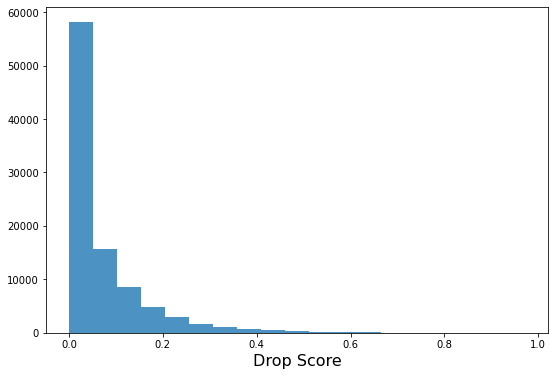

count    95187.000000
mean         0.066711
std          0.097062
min          0.000000
25%          0.000000
50%          0.032258
75%          0.092784
max          0.972565
Name: drop_score, dtype: float64

In [131]:
#Histogram of drops

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(df.drop_score.min(), df.drop_score.max(), 20)

plt.hist(df.drop_score, bins = bins, density=False, alpha = 0.8)
#plt.title('Distribution of Drop Time before window', fontsize=19)
plt.xlabel('Drop Score',fontsize=16)
plt.show()

df['drop_score'].describe()

In [152]:
#df_sum['tr_drop'] = df_sum['drop_score'].apply(lambda x: np.sqrt(x))
dft['tr_drop'] = dft['drop_score'].apply(lambda x: x**(1/3))
dft.head()

,driver_id,order_count,order_count8,avg_orders4,avg_orders8,avg_signups,total_signups,pct_peak,pct_completed,drop_score,tr_drop,tr_completed
0,100243613,8,24,2.00,3.000,58.50,234.0,0.455556,1.000000,0.000000,0.000000,1.000000
1,403521,110,245,27.50,30.625,33.00,132.0,0.244444,0.860000,0.129555,0.506001,0.927362
2,100465053,26,42,6.50,5.250,45.50,182.0,0.333333,0.920000,0.016064,0.252321,0.959166
3,920308,3,3,0.75,0.375,0.75,3.0,0.187500,0.863636,0.000000,0.000000,0.929320
4,602506,22,39,5.50,4.875,11.25,45.0,0.188889,0.960000,0.012097,0.229557,0.979796


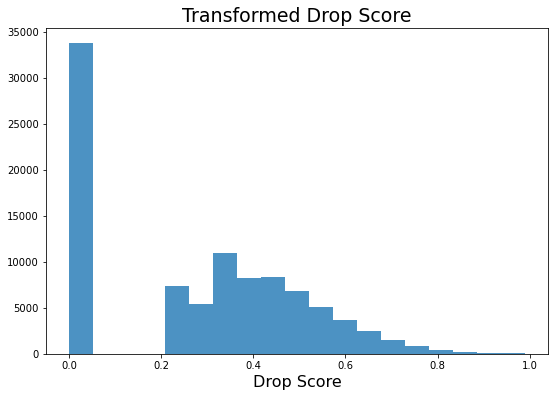

count    95187.000000
mean         0.276227
std          0.231568
min          0.000000
25%          0.000000
50%          0.318331
75%          0.452714
max          0.990770
Name: tr_drop, dtype: float64

In [153]:
#Histogram of drops

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(dft.tr_drop.min(), dft.tr_drop.max(), 20)

plt.hist(dft.tr_drop, bins = bins, density=False, alpha = 0.8)
plt.title('Transformed Drop Score', fontsize=19)
plt.xlabel('Drop Score',fontsize=16)
plt.show()

dft['tr_drop'].describe()

# Completion Rate

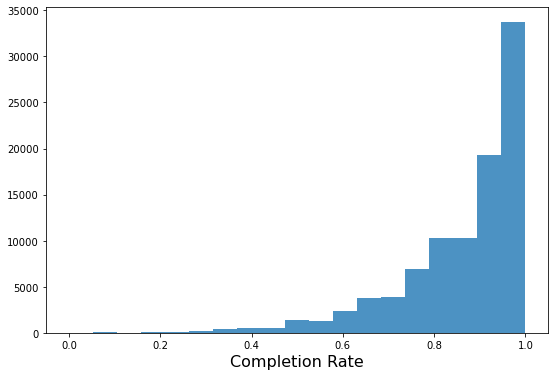

count    95187.000000
mean         0.866721
std          0.141020
min          0.000000
25%          0.800000
50%          0.909091
75%          0.980000
max          1.000000
Name: pct_completed, dtype: float64

In [134]:
#Histogram of completion rate

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(df.pct_completed.min(), df.pct_completed.max(), 20)

plt.hist(df.pct_completed, bins = bins, density=False, alpha = 0.8)
#plt.title('Distribution of Drop Time before window', fontsize=19)
plt.xlabel('Completion Rate',fontsize=16)
plt.show()

df['pct_completed'].describe()

In [135]:
dft['tr_completed'] = dft['pct_completed'].apply(lambda x: x**(1/2))
dft.head()

,driver_id,order_count,order_count8,avg_orders4,avg_orders8,avg_signups,total_signups,pct_peak,pct_completed,drop_score,tr_drop,tr_completed
0,100243613,8,24,2.00,3.000,58.50,234.0,0.455556,1.000000,0.000000,0.000000,1.000000
1,403521,110,245,27.50,30.625,33.00,132.0,0.244444,0.860000,0.129555,0.506001,0.927362
2,100465053,26,42,6.50,5.250,45.50,182.0,0.333333,0.920000,0.016064,0.252321,0.959166
3,920308,3,3,0.75,0.375,0.75,3.0,0.187500,0.863636,0.000000,0.000000,0.929320
4,602506,22,39,5.50,4.875,11.25,45.0,0.188889,0.960000,0.012097,0.229557,0.979796


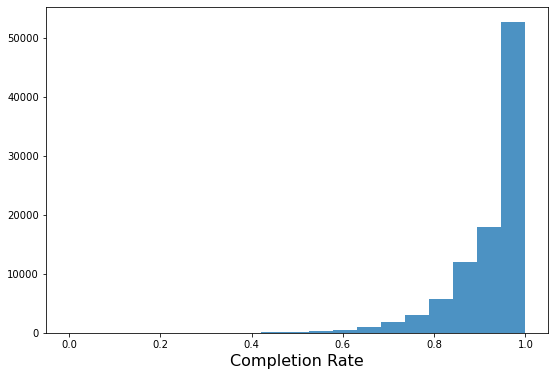

count    95187.000000
mean         0.927223
std          0.083535
min          0.000000
25%          0.894427
50%          0.953463
75%          0.989949
max          1.000000
Name: tr_completed, dtype: float64

In [136]:
#Histogram of drops

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(dft.tr_completed.min(), dft.tr_completed.max(), 20)

plt.hist(dft.tr_completed, bins = bins, density=False, alpha = 0.8)
#plt.title('Transformed Drop Score', fontsize=19)
plt.xlabel('Completion Rate',fontsize=16)
plt.show()

dft['tr_completed'].describe()

# Signups

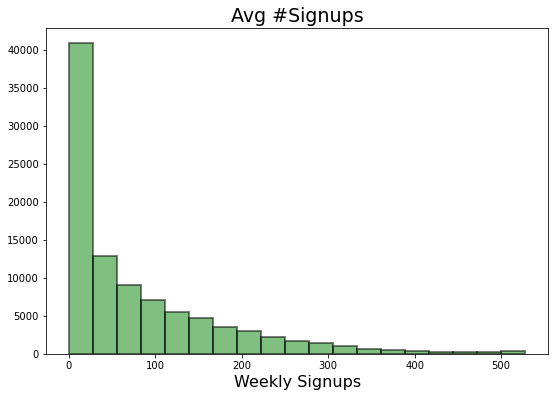

count    95187.000000
mean        79.146942
std         96.375604
min          0.000000
25%          7.000000
50%         41.000000
75%        119.000000
max        528.000000
Name: total_signups, dtype: float64

In [137]:
#Histogram of signups

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(df['total_signups'].min(), df['total_signups'].max(), 20)

plt.hist(df['total_signups'], bins = bins, density=False, alpha = 0.5,
         color = 'green', edgecolor = 'black', linewidth=2)
plt.title('Avg #Signups', fontsize=19)
plt.xlabel('Weekly Signups',fontsize=16)
plt.show()

df['total_signups'].describe()

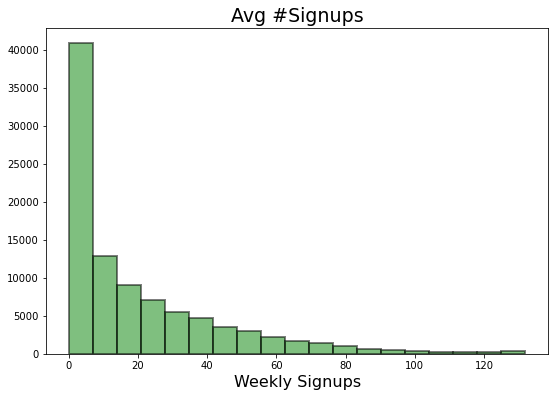

count    95187.000000
mean        19.786736
std         24.093901
min          0.000000
25%          1.750000
50%         10.250000
75%         29.750000
max        132.000000
Name: avg_signups, dtype: float64

In [138]:
#Histogram of signups

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(df['avg_signups'].min(), df['avg_signups'].max(), 20)

plt.hist(df['avg_signups'], bins = bins, density=False, alpha = 0.5,
         color = 'green', edgecolor = 'black', linewidth=2)
plt.title('Avg #Signups', fontsize=19)
plt.xlabel('Weekly Signups',fontsize=16)
plt.show()

df['avg_signups'].describe()

# Power Transforms

In [141]:
cols = ['avg_orders4', 'avg_signups', 'pct_peak', 'pct_completed', 'drop_score']
trans = df[cols].copy(deep=True)
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95187 entries, 0 to 95186
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   avg_orders4    95187 non-null  float64
 1   avg_signups    95187 non-null  float64
 2   pct_peak       95187 non-null  float64
 3   pct_completed  95187 non-null  float64
 4   drop_score     95187 non-null  float64
dtypes: float64(5)
memory usage: 3.6 MB


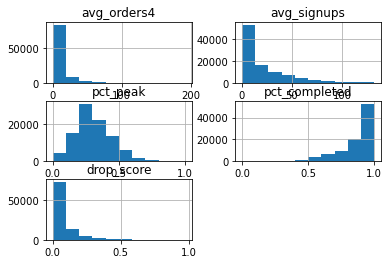

In [142]:
trans.hist()
plt.show()

In [143]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

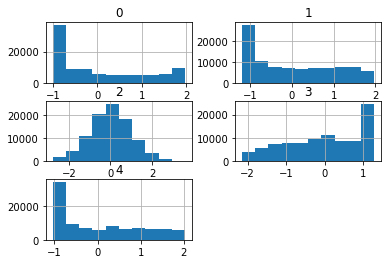

In [145]:
# perform a box-cox transform of the dataset
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
trans_df = pipeline.fit_transform(trans)
# convert the array back to a dataframe
trans_df = pd.DataFrame(trans_df)
# histograms of the variables
trans_df.hist()
plt.show()

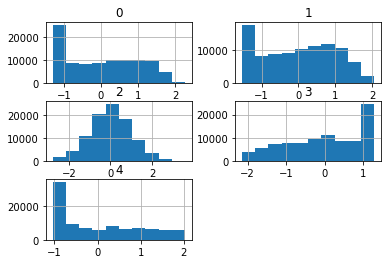

In [154]:
# perform a box-cox transform of the dataset
pt = PowerTransformer(method='yeo-johnson')
trans_df = pt.fit_transform(trans)
# convert the array back to a dataframe
trans_df = pd.DataFrame(trans_df)
# histograms of the variables
trans_df.hist()
plt.show()

In [155]:
trans_df.columns = cols
trans_df.head()

,avg_orders4,avg_signups,pct_peak,pct_completed,drop_score
0,-0.128016,1.370650,1.083430,1.278746,-1.040831
1,1.471047,0.914916,-0.394492,-0.369007,1.204062
2,0.633646,1.167405,0.278196,0.222077,-0.555762
3,-0.665575,-1.191804,-0.871927,-0.337329,-1.040831
4,0.525985,0.133709,-0.859801,0.707276,-0.667231


In [161]:
trans_df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_orders4,95187.0,-1.782427e-15,1.000005,-1.306721,-1.040167,-0.054240,0.887908,2.270603
avg_signups,95187.0,1.104872e-15,1.000005,-1.536795,-0.901822,0.071342,0.835206,2.062002
pct_peak,95187.0,-1.153817e-15,1.000005,-2.778464,-0.669149,0.001531,0.659744,3.585656
pct_completed,95187.0,-9.910490e-16,1.000005,-2.144822,-0.825404,0.103162,0.981443,1.278746
drop_score,95187.0,-1.380690e-16,1.000005,-1.040831,-1.040831,-0.150304,0.850376,2.025430


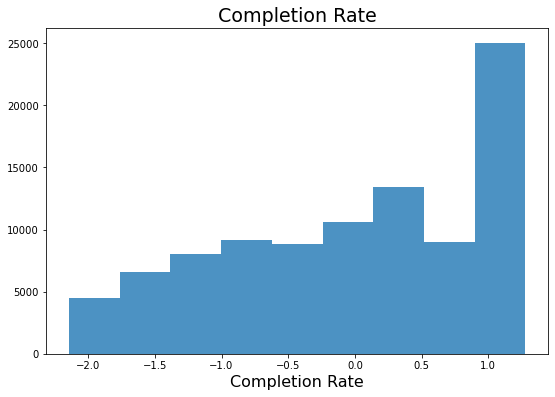

In [158]:
#Histogram of completion rate

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(trans_df.pct_completed.min(), trans_df.pct_completed.max(), 10)

plt.hist(trans_df.pct_completed, bins = bins, density=False, alpha = 0.8)
plt.title('Completion Rate', fontsize=19)
plt.xlabel('Completion Rate',fontsize=16)
plt.show()


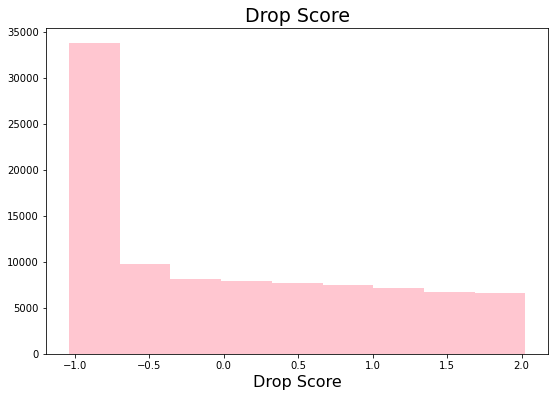

In [166]:
#Histogram of drop rate

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(trans_df.drop_score.min(), trans_df.drop_score.max(), 10)

plt.hist(trans_df.drop_score, bins = bins, density=False, alpha = 0.9, color = 'pink')
plt.title('Drop Score', fontsize=19)
plt.xlabel('Drop Score',fontsize=16)
plt.show()


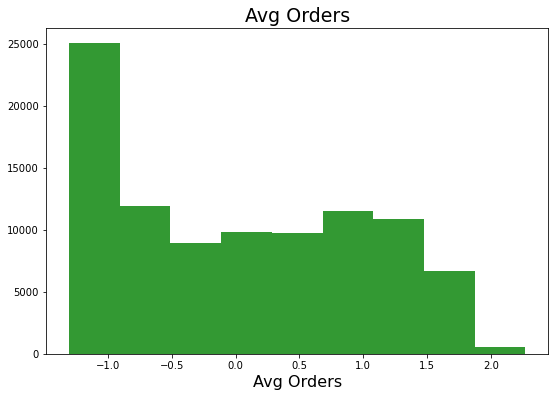

In [167]:
#Histogram of orders

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(trans_df.avg_orders4.min(), trans_df.avg_orders4.max(), 10)

plt.hist(trans_df.avg_orders4, bins = bins, density=False, alpha = 0.8, color = 'green')
plt.title('Avg Orders', fontsize=19)
plt.xlabel('Avg Orders',fontsize=16)
plt.show()


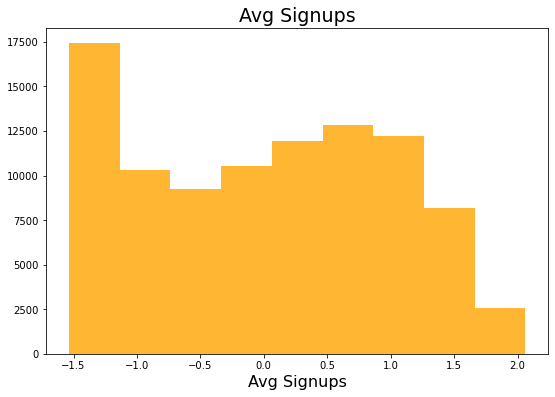

In [168]:
#Histogram of signups

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(trans_df.avg_signups.min(), trans_df.avg_signups.max(), 10)

plt.hist(trans_df.avg_signups, bins = bins, density=False, alpha = 0.8, color = 'orange')
plt.title('Avg Signups', fontsize=19)
plt.xlabel('Avg Signups',fontsize=16)
plt.show()


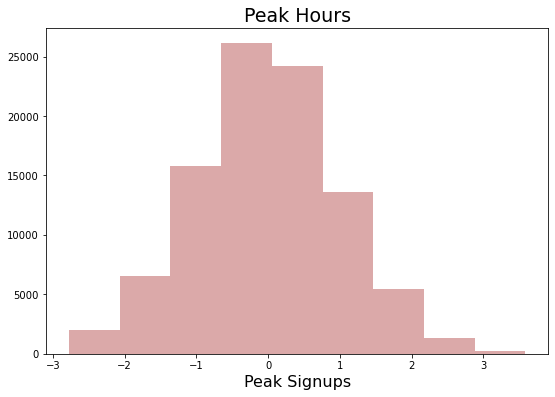

In [169]:
#Histogram of drop rate

fig,ax = plt.subplots(figsize=(9,6))
bins = np.linspace(trans_df.pct_peak.min(), trans_df.pct_peak.max(), 10)

plt.hist(trans_df.pct_peak, bins = bins, density=False, alpha = 0.4, color = 'brown')
plt.title('Peak Hours', fontsize=19)
plt.xlabel('Peak Signups',fontsize=16)
plt.show()


# Clustering

In [172]:
dfc = df.copy(deep=True)

In [170]:
from sklearn.cluster import KMeans

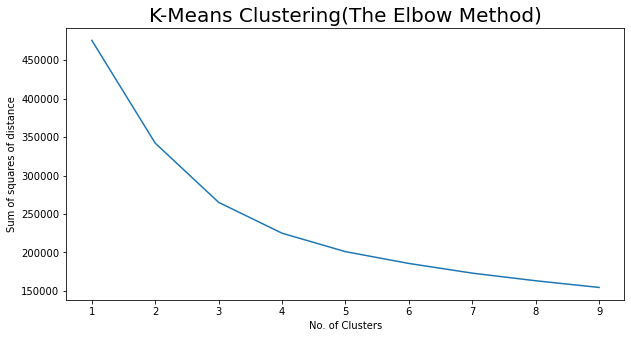

In [171]:
distance_ss = []

for i in range(1,10):
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(trans_df)
    distance_ss.append(km.inertia_)
    
fig, ax = plt.subplots(figsize = (10,5))

plt.plot(range(1,10), distance_ss)
plt.title('K-Means Clustering(The Elbow Method)', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('Sum of squares of distance')
plt.show()

In [173]:
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 11)
km.fit(trans_df)
dfc['cluster'] = km.labels_
centroids = km.cluster_centers_


In [177]:
trans_df['cluster'] = km.labels_

In [180]:
trans_df['cluster'].value_counts()

3    28541
2    27072
1    20176
0    19398
Name: cluster, dtype: int64

### Visual

In [174]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

In [175]:
X = trans_df.copy()
y = km.labels_

#T-SNE
X_tsne = TSNE(n_components = 2, random_state = 42).fit_transform(X.values)

#PCA
X_pca = PCA(n_components = 2, random_state = 42).fit_transform(X.values)

#SVD
X_svd = TruncatedSVD(n_components = 2, algorithm = 'randomized', random_state = 42).fit_transform(X.values)


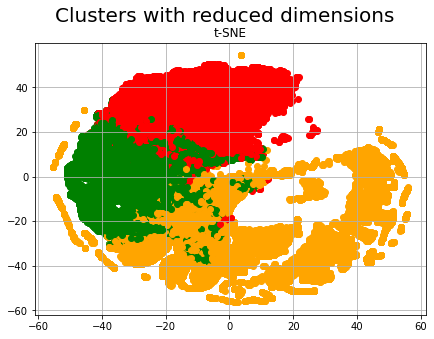

In [189]:
fig,ax1 = plt.subplots(figsize=(7,5))
fig.suptitle('Clusters with reduced dimensions', fontsize =20)

#t-SNE Cluster
for i in range(len(trans_df)):
    if trans_df['cluster'].iloc[i] == 0:
        c1 = ax1.scatter(X_tsne[i,0], X_tsne[i,1], c = 'g')
    elif trans_df['cluster'].iloc[i] == 1:
        c2 = ax1.scatter(X_tsne[i,0], X_tsne[i,1], c = 'r')
    elif trans_df['cluster'].iloc[i] == 2:
        c3 = ax1.scatter(X_tsne[i,0], X_tsne[i,1], c = 'orange')
    elif trans_df['cluster'].iloc[i] == 2:
        c4 = ax1.scatter(X_tsne[i,0], X_tsne[i,1], c = 'blue')

ax1.set_title('t-SNE')
ax1.grid(True)

In [193]:
tsn1 = [item[0] for item in X_tsne]
tsn2 = [item[1] for item in X_tsne]
tsn_df = pd.DataFrame({'component_1':tsn1, 'component_2':tsn2})

In [197]:
tsn_df['cluster'] = km.labels_
tsn_df.head()

,component_1,component_2,cluster
0,36.660160,-0.102867,3
1,2.632105,39.470272,1
2,23.806557,14.485848,3
3,-2.117161,-35.890686,2
4,1.972115,4.199712,3


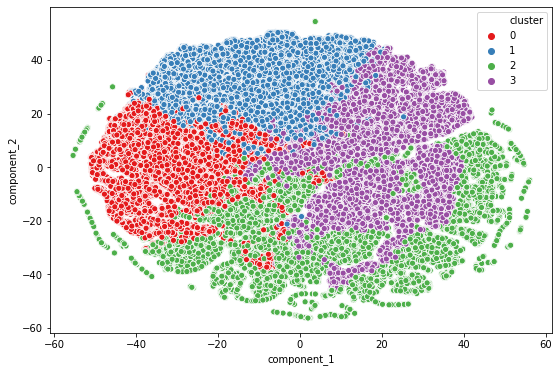

In [200]:
#Histogram of drop rate

fig,ax = plt.subplots(figsize=(9,6))

sns.scatterplot(data=tsn_df, x='component_1', y='component_2',
                hue='cluster', palette='Set1')
#plt.title('Peak Hours', fontsize=19)
#plt.xlabel('Peak Signups',fontsize=16)
plt.show()


In [201]:
trans_df.shape

(95187, 6)

In [202]:
df.shape

(95187, 10)

In [206]:
cols

['avg_orders4', 'avg_signups', 'pct_peak', 'pct_completed', 'drop_score']

In [205]:
df['cluster'] = km.labels_

In [240]:
clust_sum = df.groupby(by='cluster',as_index=False)['avg_orders4', 'avg_signups', 'pct_peak', 'pct_completed', 'drop_score'].mean()
clust_sum

,cluster,avg_orders4,avg_signups,pct_peak,pct_completed,drop_score
0,0,0.885723,5.416409,0.320720,0.739409,0.128114
1,1,15.752887,37.778103,0.300356,0.749215,0.157149
2,2,0.780705,3.542008,0.312993,0.958377,0.007683
3,3,13.457062,32.243868,0.298989,0.949378,0.017036


In [256]:
#clust_sum.to_excel('cluster_profiles.xlsx',index=False)

In [244]:
clust_melt = pd.melt(clust_sum,id_vars='cluster', var_name='metric')
clust_melt

,cluster,metric,value
0,0,avg_orders4,0.885723
1,1,avg_orders4,15.752887
2,2,avg_orders4,0.780705
3,3,avg_orders4,13.457062
4,0,avg_signups,5.416409
5,1,avg_signups,37.778103
6,2,avg_signups,3.542008
7,3,avg_signups,32.243868
8,0,pct_peak,0.320720
9,1,pct_peak,0.300356


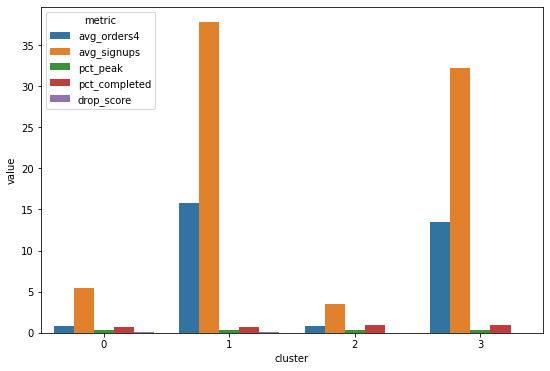

In [248]:
fig,ax = plt.subplots(figsize=(9,6))
sns.barplot(data=clust_melt,x='cluster',y='value',hue='metric')
plt.show()

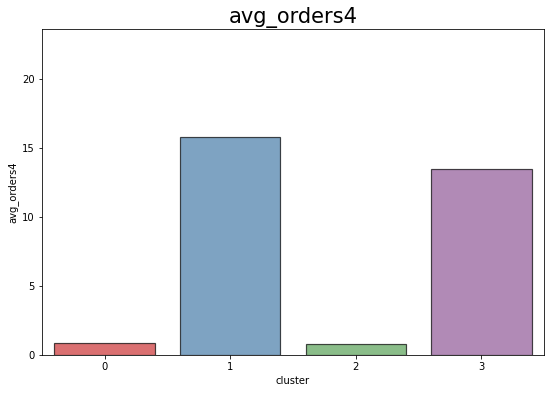

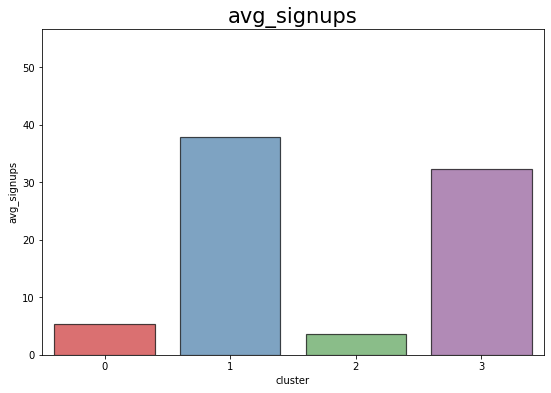

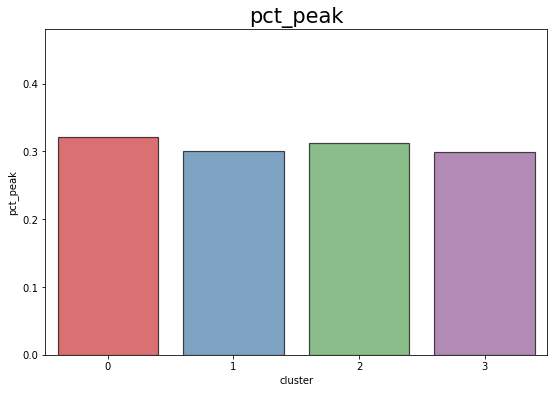

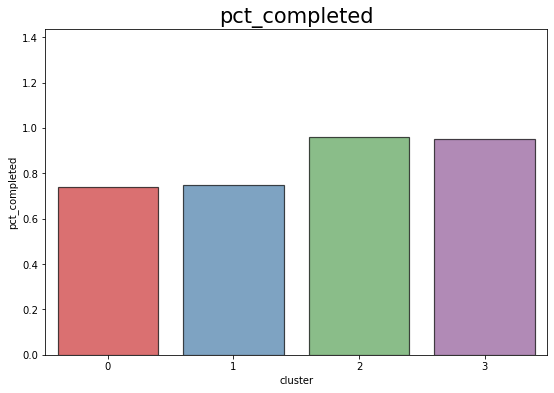

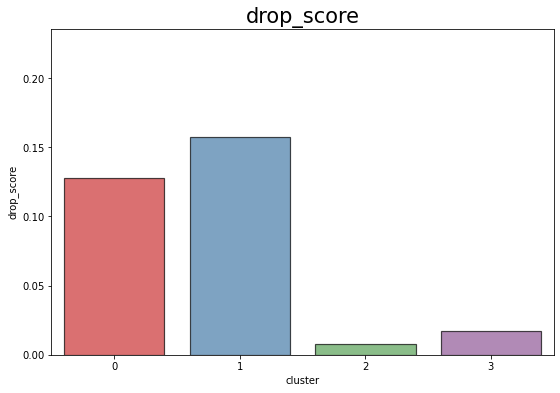

In [255]:
for metric in clust_sum.columns[1:]:
    fig,ax = plt.subplots(figsize=(9,6))
    mx = clust_sum[metric].max() * 1.5
    sns.barplot(data=clust_sum,x='cluster',y=metric,
               linewidth=1.2, edgecolor='black',palette='Set1', alpha=0.7)
    plt.ylim([0,mx])
    plt.title(metric, fontsize=21)
    plt.show()

In [261]:
clust_cnts = df.groupby(by='cluster',as_index=False)['driver_id'].count()
clust_cnts['pct_total'] = clust_cnts['driver_id']/clust_cnts['driver_id'].sum()
clust_cnts

,cluster,driver_id,pct_total
0,0,19398,0.203788
1,1,20176,0.211962
2,2,27072,0.284409
3,3,28541,0.299841


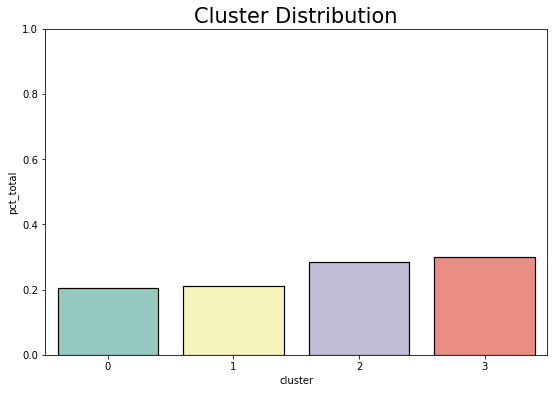

In [260]:
fig,ax = plt.subplots(figsize=(9,6))

sns.barplot(data=clust_cnts,x='cluster',y='pct_total',
           linewidth=1.2, edgecolor='black',palette='Set3', alpha=1)

plt.ylim([0,1])
plt.title('Cluster Distribution', fontsize=21)
plt.show()

In [262]:
clust_cnts['pct_total'].sum()

1.0